## **SENTIMENT ANALYSIS ON IMDB 50K Dataset**


In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 113.4 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

from sklearn.model_selection import train_test_split
from transformers import InputExample, InputFeatures
from transformers import BertTokenizer, TFBertForSequenceClassification

In [ ]:
#Build our model with sequence classifier and our tokenizer with BERT Tokenizer
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased", hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.25)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
model.summary()

Model: "tf_bert_for_sequence_classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  1538      
                                                                 
Total params: 109,483,778
Trainable params: 109,483,778
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Loading the dataset
data = pd.read_csv("/content/IMDB Dataset.csv")
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
# changing positive and negative into numeric values

def senti_val(value):
    if value=='positive': 
        return 1
    else: 
        return 0
    
data['sentiment']  =  data['sentiment'].apply(senti_val)

In [ ]:
#spliting our dataset into train and test
train, test = train_test_split(data, test_size=0.20)

In [ ]:
#checking if there a null values
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [ ]:
#  BERT tokenizer 
#convert text into tokens and their corresponding IDs.
token_example = 'This is a beautiful world , Face it with a Smile'
encoded = []
for word in token_example.split():
    tokens = tokenizer.tokenize(word)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)
    encoded.extend(token_ids)
    print(tokens)
print(encoded)

['this']
['is']
['a']
['beautiful']
['world']
[',']
['face']
['it']
['with']
['a']
['smile']
[2023, 2003, 1037, 3376, 2088, 1010, 2227, 2009, 2007, 1037, 2868]


In [ ]:
#In this function, each row will be transformed into an InputExample object using the train and test datasets as input.
def sample_convert(train, test, review, sentiment):
    train_set_sample = []
    for i, r in train.iterrows():
        train_set_sample.append(InputExample(guid=None, 
                                                 text_a = r[review], 
                                                 label = r[sentiment]))

    validation_set_sample = []
    for i, r in test.iterrows():
        validation_set_sample.append(InputExample(guid=None, 
                                                      text_a = r[review], 
                                                      label = r[sentiment]))
  
    return train_set_sample, validation_set_sample

train_set_sample, validation_set_sample = sample_convert(train,  test, 'review',  'sentiment')

In [ ]:

# Define the function that takes in the sample examples, tokenizer, and max_length
def example_tf_dataset(sample_examples, tokenizer, max_length=128):
  # Define an empty list to store the input features
    input_features = [] 
# Loop through the sample examples using tqdm to display progress bar
    for i in tqdm(sample_examples):
      # Tokenize the text using the given tokenizer with required arguments
        input_dict = tokenizer.encode_plus(
            i.text_a,
            add_special_tokens=True,    
            max_length=max_length,    
            return_token_type_ids=True,
            return_attention_mask=True,
            pad_to_max_length=True, 
            truncation=True
        )
 # Get the input_ids, token_type_ids, and attention_mask from the input_dict
        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],input_dict["token_type_ids"], input_dict['attention_mask'])
        # Append the input features to the list
        input_features.append(InputFeatures( input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=i.label) )
# Define a generator function to yield the input features
    def func_gen():
        for j in input_features:
            yield (
                {
                    "input_ids": j.input_ids,
                    "attention_mask": j.attention_mask,
                    "token_type_ids": j.token_type_ids,
                },
                j.label,
            )
# Return a tensorflow dataset generated from the generator function
    return tf.data.Dataset.from_generator(
        func_gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

# Define the names of the data column and label column
column_data = 'review'
column_label = 'sentiment'

In [ ]:
#tokenizing our train data
train_data = example_tf_dataset(list(train_set_sample), tokenizer)
train_data = train_data.shuffle(100).batch(8).repeat(2)

  0%|          | 0/40000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
100%|██████████| 40000/40000 [03:14<00:00, 205.79it/s]


In [ ]:
#tokenizing our test data
validation_data = example_tf_dataset(list(validation_set_sample), tokenizer)
validation_data = validation_data.batch(8)

100%|██████████| 10000/10000 [00:46<00:00, 217.26it/s]


In [ ]:
epochs=2
#epochs=5

In [ ]:
#Fit the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

In [ ]:
training_history = model.fit(train_data, epochs=epochs, validation_data=validation_data)

Epoch 1/2
10000/10000 [==============================] - 2560s 251ms/step - loss: 0.1242 - accuracy: 0.9555 - val_loss: 0.5154 - val_accuracy: 0.8812
Epoch 2/2
10000/10000 [==============================] - 2494s 249ms/step - loss: 0.0580 - accuracy: 0.9813 - val_loss: 0.6369 - val_accuracy: 0.8877


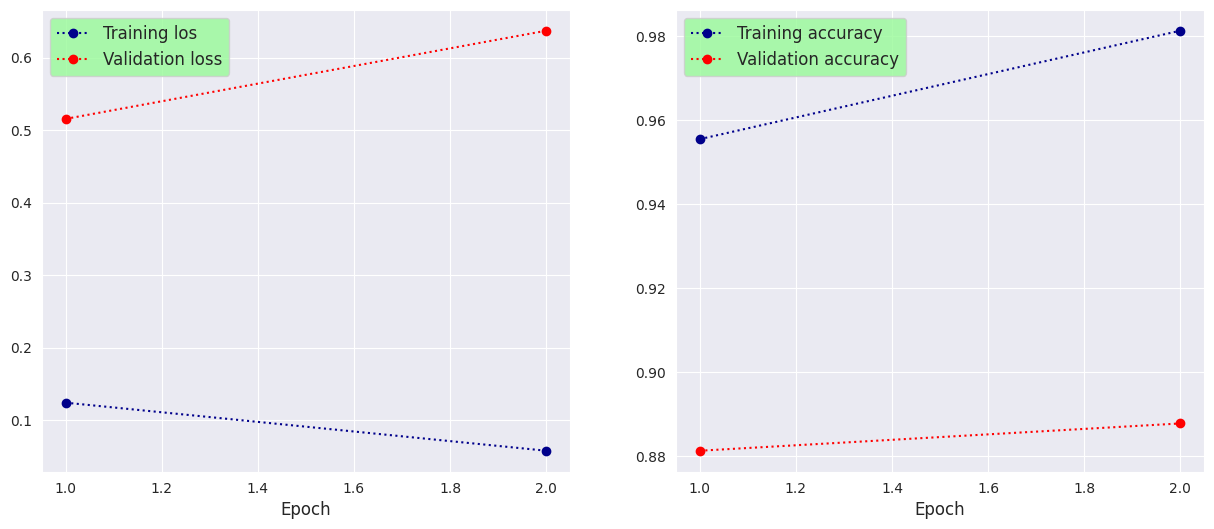

In [ ]:
#Save the the values of the epochs in "epoch values"
ep_values = range(1, epochs+1)

# Plot of the training loss and validation loss

with sns.axes_style("darkgrid"):

    _, (loss, acc) = plt.subplots(1, 2, figsize=(15, 6))
    loss.plot(ep_values, training_history.history['loss'], color='darkblue', linestyle='dotted',
              marker='o', label='Training loss')
    loss.plot(ep_values, training_history.history['val_loss'], color='r', linestyle='dotted',
              marker='o', label='Validation loss')
    loss.set_xlabel('Epoch', size='large')
    loss.legend(fontsize='large', facecolor='palegreen')

    acc.plot(ep_values, training_history.history['accuracy'], color='darkblue', linestyle='dotted',
             marker='o', label='Training accuracy')
    acc.plot(ep_values, training_history.history['val_accuracy'], color='r', linestyle='dotted',
             marker='o', label='Validation accuracy')
    acc.set_xlabel('Epoch', size='large')
    acc.legend(fontsize='large', facecolor='palegreen')

    plt.show()

# epoch_values = range(1, epochs+1)

# # Plotting  training loss and validation loss
# fig, axs = plt.subplots(1, 2, figsize=(15, 6))
# sns.lineplot(data=training_history.history['accuracy'], label="Training accuracy", ax=axs[0])
# sns.lineplot(data=training_history.history['val_accuracy'], label="Validation accuracy", ax=axs[0])
# axs[0].set_xlabel('Epoch', size='large')
# axs[0].legend(fontsize='large', facecolor='palegreen')
# sns.lineplot(data=training_history.history['loss'], label="Training loss", ax=axs[1])
# sns.lineplot(data=training_history.history['val_loss'], label="Validation loss", ax=axs[1])
# axs[1].set_xlabel('Epoch', size='large')
# axs[1].legend(fontsize='large', facecolor='palegreen')
# plt.show()

In [ ]:
samp_pred= ["""Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. <br /><br />The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only."""]

In [ ]:
encoded_dict = tokenizer(samp_pred, padding=True, truncation=True, max_length=128, return_tensors='tf')

In [ ]:
# Get the model predictions
outputs = model(encoded_dict)
predictions = tf.nn.softmax(outputs.logits, axis=-1)
predicted_labels = tf.argmax(predictions, axis=1)

In [ ]:
# Map the predicted labels to the actual labels
labels = ['Negative', 'Positive']
predicted_labels = predicted_labels.numpy()
predicted_labels = [labels[label] for label in predicted_labels]

In [ ]:
# Print the predicted labels
for sentence, label in zip(samp_pred, predicted_labels):
    print(f"{sentence}: {label}")

Encouraged by the positive comments about this film on here I was looking forward to watching this film. Bad mistake. I've seen 950+ films and this is truly one of the worst of them - it's awful in almost every way: editing, pacing, storyline, 'acting,' soundtrack (the film's only song - a lame country tune - is played no less than four times). The film looks cheap and nasty and is boring in the extreme. Rarely have I been so happy to see the end credits of a film. <br /><br />The only thing that prevents me giving this a 1-score is Harvey Keitel - while this is far from his best performance he at least seems to be making a bit of an effort. One for Keitel obsessives only.: Negative


In [ ]:
model.save_weights('/content/models')

In [ ]:
! pip install bert_score

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.1/61.1 kB 4.5 MB/s eta 0:00:00


In [ ]:
model.evaluate(validation_data)

1250/1250 [==============================] - 111s 89ms/step - loss: 0.6369 - accuracy: 0.8877


[0.6369495391845703, 0.8877000212669373]

In [ ]:
y_pred = model.predict(validation_data)

1250/1250 [==============================] - 107s 83ms/step


In [ ]:
type(y_pred)

transformers.modeling_tf_outputs.TFSequenceClassifierOutput

In [ ]:
y_true = tf.Variable([], dtype=tf.int64)

for features, label in validation_data.take(-1):
    y_true = tf.concat([y_true, label], 0)

In [ ]:
y_pred

TFSequenceClassifierOutput(loss=None, logits=array([[-3.6907635,  3.7805467],
       [ 4.839651 , -4.6539636],
       [-5.2793465,  5.375764 ],
       ...,
       [-6.0159364,  6.13859  ],
       [-1.7897357,  1.9291625],
       [-4.044269 ,  4.15146  ]], dtype=float32), hidden_states=None, attentions=None)

In [ ]:
tf.nn.softmax(y_pred.logits)

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[5.6885829e-04, 9.9943107e-01],
       [9.9992466e-01, 7.5325675e-05],
       [2.3579474e-05, 9.9997640e-01],
       ...,
       [5.2644655e-06, 9.9999475e-01],
       [2.3686042e-02, 9.7631401e-01],
       [2.7575297e-04, 9.9972421e-01]], dtype=float32)>

In [ ]:
y_pred_argmax = tf.math.argmax(tf.nn.softmax(y_pred.logits), axis=1)

In [ ]:
y_true

<tf.Tensor: shape=(10000,), dtype=int64, numpy=array([1, 0, 1, ..., 1, 1, 1])>

In [ ]:

def visualize_confusion_matrix(y_pred, y_true):

    cm = confusion_matrix(y_true, y_pred)
    con_mat_df = pd.DataFrame(cm)
    
    print(classification_report(y_pred, y_true))

    sns.heatmap(con_mat_df, annot=True, fmt='g', cmap=plt.cm.Blues)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



              precision    recall  f1-score   support

           0       0.88      0.89      0.89      4896
           1       0.90      0.88      0.89      5104

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



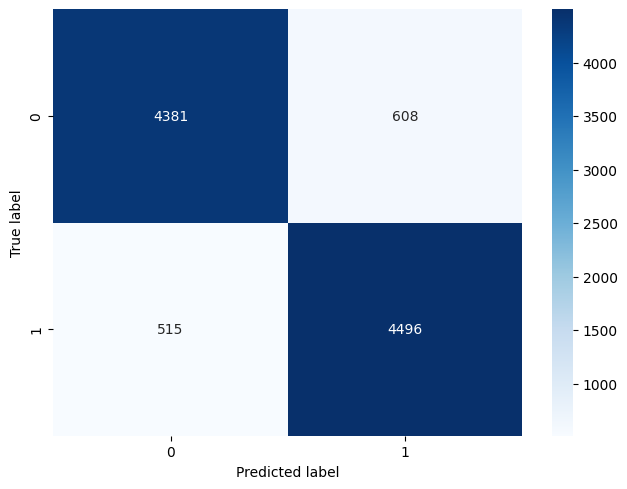

In [ ]:
visualize_confusion_matrix(y_pred_argmax, y_true)

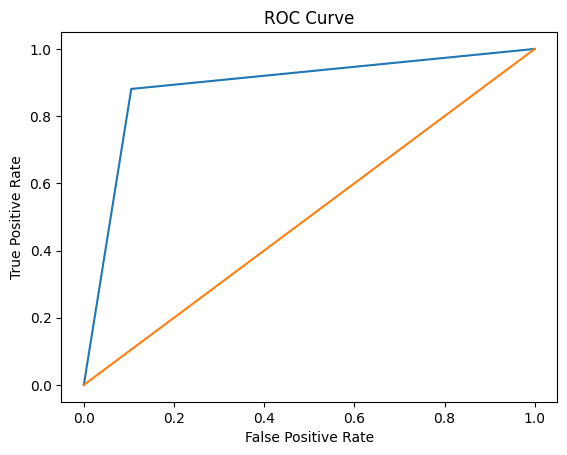

In [ ]:
fpr,tpr,thresholds = roc_curve(y_pred_argmax, y_true)
plt.plot(fpr,tpr)
plt.plot([0,1])
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

In [ ]:
roc_auc_score(y_pred_argmax, y_true)

0.8878449172249884